In [1]:
from scripts.mrs_ue_utils import generate_dem
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
from skimage.restoration import unwrap_phase
import scienceplots


# Exercise 5: **Phase Difference**

Take the master (”master img.npy”) and slave (”slave img.npy”) phase image located on the JupyterHub server under: ”∼/shared/mrs22w/data/” and generate a flat-earth corrected phase interferogram. Use the same input parameters as given
in Exercise 1. Note: You can save/pickle NumPy arrays to disk via np.save(filepath, np ar) and load them with `np_ar = np.load(filepath)`.
_Hint: One possible solution to generate a flat-earth interferogram would be to use a flat-earth model: `x, y, z = generate_dem(z_min=0., z_max=0.)`_


## 5.1 What is a flat-earth correction and why is it necessary?

Because of the side-looking geometry inherent in SAR (Synthetic Aperture Radar), a phase difference becomes noticeable with increasing distances between the sensor and pixels, even in the case of a flat Earth. To obtain an accurate DEM (Digital Elevation Model), we create a phase difference model based on a flat Earth and subtract it from our original model.


## 5.2 What do the fringes show in the interferogram?

Fringes with higher spatial frequency delineate geometries leaning towards the sensor, while frines with lower frequency indicate geometries leaning away from the sensor.


## 5.3 What parameters influence the fringe pattern?

-   The geometry of an object either increases or decreases fringe spatial frequencies
-   Local incidence angle
    -   $\theta_i$: $\lim_{\theta \rightarrow 0}: q_{fringe} \rightarrow \infty$
    -   $\theta_i$ is determined by the between sensor and facet, as well as incidence angle $\theta$ and facet angle $\alpha_i$
-   The baseline is the main parameter that influences the phase difference $\Delta\phi$


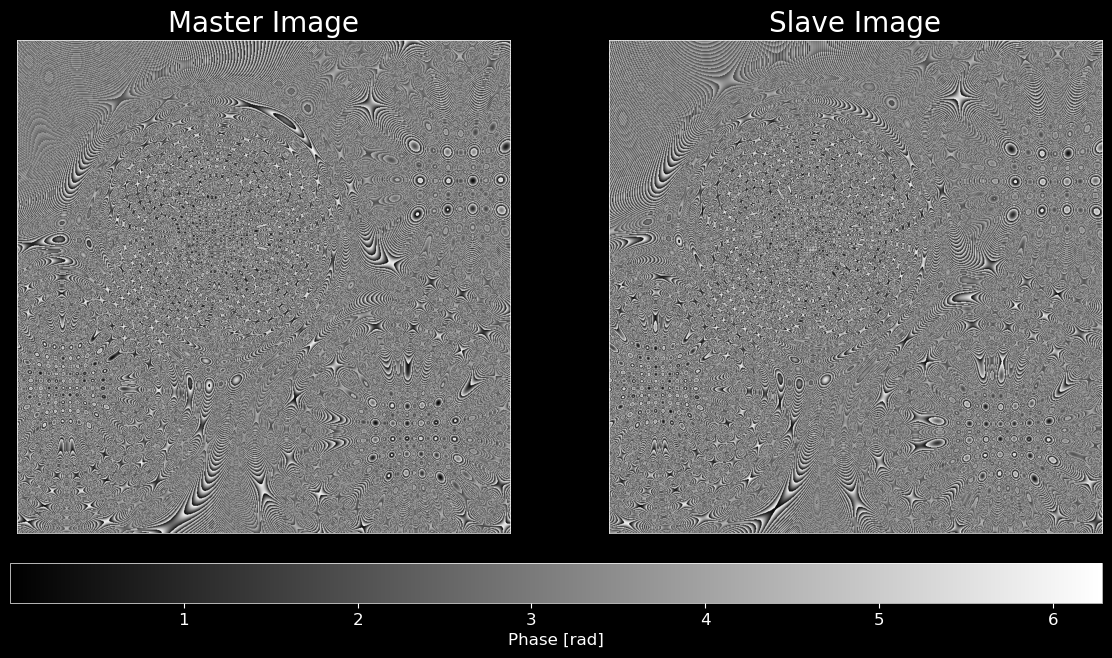

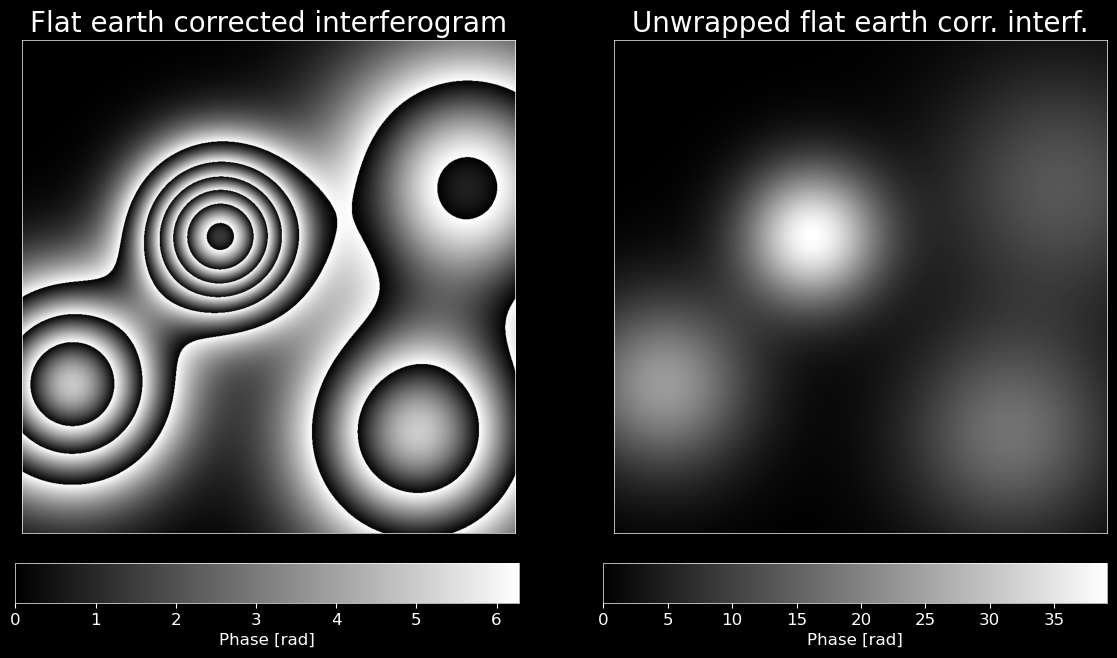

In [2]:
def angle(v, w):
    return np.arccos(v.dot(w) / (norm(v) * norm(w)))


path = "./data"

master = np.load(os.path.join(path, "e1_master_img.npy"))
slave = np.load(os.path.join(path, "e1_slave_img.npy"))

with plt.style.context('nature'):
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))
    ax[0].imshow(master, cmap='grey')
    ax[1].imshow(slave, cmap='grey')
    ax[0].set_title('Master Image', fontsize=20)
    ax[1].set_title('Slave Image', fontsize=20)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    cbar_ax = fig.add_axes([0.12, 0.1, 0.78, 0.05
                            ])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ax[1].imshow(slave, cmap='gray'),
                        cax=cbar_ax,
                        orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Phase [rad]', fontsize=12)

# Generate a flat earth DEM
x, y, z = generate_dem(z_min=0., z_max=0.)
dem = np.dstack((x, y, z))

# Position of Master and slave
p_m = np.array([0., -12_000., 10_000.])  # Master

# Direction and distance of slave
p_c = np.array([np.sqrt(0.5), np.sqrt(0.5), 0.])
b = 100.

p_s = p_m - (p_c * b)  # Slave

baseline = (p_c * b)  # Baseline between Master and Slave

lambda_ = 0.05  # Wavelength

k = 2 * np.pi / lambda_  # Wave number

R1 = dem - p_m  # Distance between master and each point of the DEM
R2 = R1 - baseline  # Distance between slave and each point of the DEM

master_dem = norm(R1, axis=2) * k % (2 * np.pi)  # Phase at master
slave_dem = norm(R2, axis=2) * k % (2 * np.pi)  # Phase at slave

r1 = norm(R1, axis=2)
r2 = norm(R2, axis=2)

interferogram = ((master - master_dem) - (slave - slave_dem)) % (2 * np.pi)
unwrapped_phases = unwrap_phase(interferogram % (2 * np.pi))
# unwrapped_phases = unwrap_phase(interferogram)
with plt.style.context('nature'):
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))
    ax[0].imshow(interferogram, cmap='grey')
    ax[1].imshow(unwrapped_phases, cmap='grey')
    ax[0].set_title('Flat earth corrected interferogram', fontsize=20)
    ax[1].set_title('Unwrapped flat earth corr. interf.', fontsize=20)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    cbar_ax = fig.add_axes([0.12, 0.1, 0.36, 0.05
                            ])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ax[1].imshow(interferogram, cmap='gray'),
                        cax=cbar_ax,
                        orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Phase [rad]', fontsize=12)

    cbar_ax = fig.add_axes([0.54, 0.1, 0.36, 0.05
                            ])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ax[1].imshow(unwrapped_phases, cmap='gray'),
                        cax=cbar_ax,
                        orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Phase [rad]', fontsize=12)
